In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import warnings
from math import floor
from statsmodels.tsa.stattools import pacf
from sklearn.base import TransformerMixin
from skits.preprocessing import HorizonTransformer
import datetime
from sktime.datasets import load_airline
from sktime.forecasting.compose import ReducedForecaster
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import lightgbm as lgb
import timeit as tmt

In [54]:
def read_data(filename, targetcol='VALUE', datecol='DATE', sep=';',
              decimal=',', date_format="%d/%m/%Y %H:%M:%S.%f", freq='1T'):
    if filename[-3:] == 'csv' or filename[-3:] == 'txt':
        file_ = pd.read_table(filename, sep=sep, decimal=decimal,
                              parse_dates=False)
        file_parsed = parsedates(file_, date_format=date_format, freq=freq,
                                 datecol=datecol)
    elif filename[-3:] == 'xls' or filename[-3:] == 'lsx':
        file_ = pd.read_excel(filename, parse_dates=False)
        file_parsed = parsedates(file_, date_format=date_format, freq=freq,
                                 datecol=datecol)
    else:
        raise NotImplementedError("This file type is not supported")

    return(file_parsed[targetcol].to_frame())


def parsedates(file_, date_format, freq, datecol):
    freq = pd.to_timedelta(freq)
    datetime_i = pd.to_datetime(file_[datecol], format=date_format)
    print(type(datetime_i.iloc[-1]))
    if freq < (datetime_i.iloc[1] - datetime_i.iloc[0]):
        raise ValueError('Expected frequency smaller than dataset information')

    file_.index = datetime_i
    desired_index = pd.date_range(start=datetime_i.iloc[0],
                                  end=datetime_i.iloc[-1], freq=freq)
    file_int = file_.reindex(file_.index.union(desired_index))
    file_int = file_int.interpolate(method='time').reindex(desired_index)

    return(file_int)


In [55]:
df = read_data(filename='NIVEL2_TOTAL_AIRE_INST_FILT.csv',
              freq='20T')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [56]:
points = 100                        ## tamaño del test para entrenar el regresor
window_length = 200                 ## tamaño de ventana para la prediccion de ventana
rolling_window = [5,10,20]          ## Cuantas caracteristicas debe tener la rolling window para el calculo de features rollo moving average
horizon = 1                         ## horizonte a predecir en cada recursion
step = 1                            ## paso que se mueve la ventana para cada recursión.
freq = '20T'                         ## Frecuencia de la serie de entrada o de prediccion

In [57]:
df.index[1] - df.index[0]



Timedelta('0 days 00:20:00')

In [58]:
%time y_train, y_test = train_test_split(df, test_size=points, shuffle=False)      ## Split en train y test sin shuffle por ser time series. Test_size se da como points
print(y_train.shape[0], y_test.shape[0])                                     ## Test para comprobar tamaños de train y test

CPU times: user 5.32 ms, sys: 0 ns, total: 5.32 ms
Wall time: 3.22 ms
2188 100


-----

#### Create train features

In [7]:
from extract_sample_features import *                                        ## Importamos el modulo desde la misma carpeta que el script

In [59]:
def create_sample_features(X, window_length = 5, features = [], rolling_window = [2]):      ## Creacion de features para los datos de entrada (se llama solo una vez)
    lags_X = lags_sample(X, window_length=window_length, step=1)                            ## Creacion de los lags (min t-1, -2 ....)
    df = lags_X.copy()                                                                      ## Copia a otro dataframe for some reason
    for f in features:                                                                      ## Features contiene la lista de features que queremos añadir al dataframe con lags.b
        if rolling_window:                                                                  ## si se ha especificado una rolling window
            for rol in rolling_window:   
                aux = switch_sample_features(f, X, lags_X, rol)                             ## Variable auxiliar para crear la feature (se borra a cada iteracion) con los lags (la fila vaya)
                df = pd.concat([df, aux], axis = 1).dropna()                                ## concatenamos el valor al dataframe
        else:
            aux = switch_sample_features(f, X, lags_X, [])                                  ## opcion sin rolling windows
            df = pd.concat([df, aux], axis = 1).dropna()                                    ## añadir a dataframe
    return df

In [60]:
def switch_sample_features(value, X, lags_X, rolling_window):                               ## Switch con el que elegir las caracteristicas del sample.
    return { 
        'mean': lambda : mean_sample(lags_X, rolling_window),
        'std': lambda : std_sample(lags_X, rolling_window),
        'max': lambda : max_sample(lags_X, rolling_window),
        'min': lambda : min_sample(lags_X, rolling_window),
        'quantile': lambda : quantile_sample(lags_X, rolling_window),
        'iqr': lambda : iqr_sample(lags_X, rolling_window),
        'entropy': lambda : entropy_sample(lags_X, rolling_window),
        'trimmean': lambda : trimmean_sample(lags_X, rolling_window),
        'variation': lambda : variation_sample(lags_X, rolling_window),
        'hmean': lambda : hmean_sample(lags_X, rolling_window),
        'gmean': lambda : gmean_sample(lags_X, rolling_window),
        'mad': lambda : mad_sample(lags_X, rolling_window),
#         'gstd': lambda : gstd_sample(lags_X, rolling_window),
        'tvar': lambda : tvar_sample(lags_X, rolling_window),
        'kurtosis': lambda : kurtosis_sample(lags_X, rolling_window),
        'sem': lambda : sem_sample(lags_X, rolling_window),
        'wav': lambda : wav_sample(lags_X, rolling_window),
        #-----------------------------------------
        'minute': lambda : minute_sample(X),
        'hour': lambda : hour_sample(X),
        'dayofweek': lambda : dayofweek_sample(X),
        'day': lambda : day_sample(X),
        'month': lambda : month_sample(X),
        'quarter': lambda : quarter_sample(X),
        'weekofyear': lambda : weekofyear_sample(X),
        'weekend': lambda : weekend_sample(X)
        
    }.get(value)()

#### Create horizon

In [61]:
def create_horizon(df, horizon):
    y = df.copy()
    ht = HorizonTransformer(horizon = horizon+1)
    y_horizon = ht.fit_transform(y.iloc[:,0]) #Los horizon ultimos valores son nan ya que no se puede crear un horizonte completo para ellos
    y_horizon = pd.DataFrame(y_horizon[:-horizon, :], index = y.index[horizon:])
    name = 't+'+str(horizon)
    y_horizon = pd.DataFrame({name : y_horizon.iloc[:, -1]})
    
    return y_horizon

#### Feature selection

In [62]:
def feature_selection(X, y, num_features):                                ## Elegimos componente principales entrenando un lgbmr y extrayendo los best_features
    clf = lgb.LGBMRegressor(n_estimators=40).fit(X, y)                    ## Fit modelo con poquitos estimators (40)
    best_indx_col = clf.feature_importances_.argsort()[-num_features:]    ## elegimos el num_features que nos queramos quedar
    best_features = list(X_train.columns[best_indx_col])                  ## Creamos lista para indexar el dataframe
    return order_by_other_list(X_train.columns, best_features)            ## devolvemos una lista de columnas ordenadas por su utilidad 

------

In [63]:
def order_by_other_list(list_order, list_tobe_order):                     ## Orden de la lista y lista a ordenar
    d = {k:v for v,k in enumerate(list_order)}                            ## creas un dict key:value for enumerate tal
    list_tobe_order.sort(key=d.get)                                       ## le das un sort con key = d.get (pillamos la key del dict)
    return list_tobe_order

----

In [64]:
from extract_features import *                                            ## Importamos modulo extract features para las windows, no el dataset completo

In [65]:
def switch_features(value, lags_data, date, rolling_window, num):         ## Switch igual que antes, se añade el parametro num, que significa?
    return {
        'lag': lambda : lag_feature(lags_data, num),
        #--------------------------------------------------------------
        'mean': lambda : mean_feature(lags_data, rolling_window, num),
        'std': lambda : std_feature(lags_data, rolling_window, num),
        'max': lambda : max_feature(lags_data, rolling_window, num),
        'min': lambda : min_feature(lags_data, rolling_window, num),
        'quantile': lambda : quantile_feature(lags_data, rolling_window, num),
        'iqr': lambda : iqr_feature(lags_data, rolling_window, num),
        'entropy': lambda : entropy_feature(lags_data, rolling_window, num),
        'trimmean': lambda : trimmean_feature(lags_data, rolling_window, num),
        'variation': lambda : variation_feature(lags_data, rolling_window, num),
        'hmean': lambda : hmean_feature(lags_data, rolling_window, num),
        'gmean': lambda : gmean_feature(lags_data, rolling_window, num),
        'mad': lambda : mad_feature(lags_data, rolling_window, num),
#         'gstd': lambda : gstd_feature(lags_data, rolling_window, num),
        'tvar': lambda : tvar_feature(lags_data, rolling_window, num),
        'kurtosis': lambda : kurtosis_feature(lags_data, rolling_window, num),
        'sem': lambda : sem_feature(lags_data, rolling_window, num),
        'wav': lambda : wav_feature(lags_data, rolling_window, num),
        #--------------------------------------------------------------
        'minute': lambda : minute_feature(date, num),
        'hour': lambda : hour_feature(date, num),
        'dayofweek': lambda : dayofweek_feature(date, num),
        'day': lambda : day_feature(date, num),
        'month': lambda : month_feature(date, num),
        'quarter': lambda : quarter_feature(date, num),
        'weekofyear': lambda : weekofyear_feature(date, num),
        'weekend': lambda : weekend_feature(date, num)
    }.get(value)()

In [66]:
def create_features(feature_names, lags_data, date):                       ## Creacion de features para las ventanas segun avanzan (se llama varias veces)
    features = []                                                          ## Lista vacía de features para inicializar
    for f in feature_names:                                                ## Por cada feature que nos pidan añadir
        ftype, info = f.split('_',1)                                       ## Separamos el str a la altura de la barrabaja para separar en tipo de feature (p. ej minute) y numero (p ej 60)
        if '_' in info:                                                    ## Si nos queda otra barrabaja es que es dato calculado con una rolling window
            rolling_window, num = info.split('_')                          ## separamos en rolling window y numero
            num = int(num)                                                 ## str a int
            rolling_window = int(rolling_window)                           ## str a int
        else:
            num = int(info)                                                ## tambien puede ser que no se de el caso de incluir el ftype en el nombre, asi que seguimos adelante simplemente sin rolling window
            rolling_window = None
        features.append(switch_features(ftype, lags_data, date, rolling_window, num))
                                
    return features

---

In [67]:
def switch_optimization(value, regressor):                                  ## Switch para elegir optimizaciones del regresor
    return {
        'tpe': lambda : tpe_optimization(),                                 ## TPE Tree-structured Parzen optimization (Secuencial)
        'pso': lambda : pso_optimization(),                                 ## PSO Particle Swarm Optimization (Enjambre)
    }.get(value)()

In [68]:
len(df)

2288

---

In [176]:
def recursive_forecast(y, model, window_length, feature_names, rolling_window, n_steps): ## modelo debe estar pre-entrenado
    """
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    model: pre-trained machine learning model
    lags: list of lags used for training the model
    n_steps: number of time periods in the forecasting horizon
    step: forecasting time period
   
    Returns
    -------
    fcast_values: pd.Series with forecasted values
    """
   
    # get the dates to forecast
    last_date = y.index[-1] + datetime.timedelta(minutes=15)                     ## ultima fecha, le añadimos un delay de 15 mins porque?¿ usamos 15 minutos de validacion o test 
    target_range = pd.date_range(last_date, periods=n_steps, freq=freq)          ## creamos el target a partir del ultimo dia. 
    target_value = np.arange(n_steps, dtype = float)                             ## Si no guardamos como dtype float nos guarda como enteros
    max_rol = max(rolling_window, default=1)                                     ## Maximo del array del rolling window
    lags = list(y.iloc[-(window_length+(max_rol-1)):,0].values)                  ## creacion de lags en forma de lista. Indexando el valor de las ys (solo hay ys porque es una serie temporal duh)
    ####
    
    
    for i in range(n_steps):                                                     ## Para cada uno de los steps
        train = create_features(feature_names, lags, target_range[i])            ## 
        new_value = model.predict(pd.DataFrame(train).transpose())               ## Calculo del nuevo valor
        target_value[i] = new_value[0]                                           ## Guardamos el valor en el target
        lags.pop(0)                                                              ## Quitamos el primer valor del lag
        lags.append(new_value[0])                                                ## añadimos la prediccion al final del lag
                                                                                 ## Y volvemos a gestionar con el nuevo lag
           
    return target_value

def recursive_forecast_np(y, model, window_length, feature_names, 
                          rolling_window, n_steps):
    """
    Recursive forecast function using numpy arrays

    Since keras LSTM and TCN models require numpy arrays that have specific 
    shapes to function, implement recursive forecasting on numpy arrays, 
    updating each data point with the previous one to predict the next.

    Parameters
    ----------
    y: pd.Series
        Input time series with constant frequency
    model: pre-trained model
        Keras RNN model
    scaler: Scaler
        Scaler to apply to Keras model input
    
    Returns
    -------
    pd.Series
        Forecasted values
    """
   
    # get the dates to forecast
    last_date = y.index[-1] + datetime.timedelta(minutes=15)
    target_range = pd.date_range(last_date, periods=n_steps, freq=freq) 
    target_value = np.arange(n_steps, dtype = float)       
    max_rol = max(rolling_window, default=1)     
    lags = list(y.iloc[-(window_length+(max_rol-1)):,0].values)
    ####
    
    
    for i in range(n_steps):                                  
        train = create_features(feature_names, lags, target_range[i]) 
        train_np = np.array(train, dtype=object)
        train_np_s = scaler.fit_transform(train_np.reshape(-1,1))
        new_value = model.predict(train_np_s.reshape(-1,1,len(feature_names)))
        new_valu_0 = new_value[0][0][0]
        target_value[i] = new_valu_0
        lags.pop(0)                                                
        lags.append(new_valu_0)                                   
                                                        

    return target_value

---

In [70]:
#features = ['mean', 'std', 'max', 'min', 'quantile', 'iqr', 'entropy', 'trimmean', 'variation', 'hmean', 'gmean', 'mad', 'tvar',
#            'kurtosis', 'sem', 'minute', 'hour', 'dayofweek', 'day', 'month', 'quarter', 'weekofyear', 'weekend']

features = ['mean', 'std', 'max', 'min', 'minute']                               ## Seleccion de features a incluir en los predictores

In [103]:
%time X_train = create_sample_features(y_train, window_length=window_length, features=features, rolling_window=rolling_window)
%time y_horizon = create_horizon(y_train, horizon)
%time y_horizon = y_horizon.loc[X_train.index[0]:,:]
X_train.head()

CPU times: user 1.38 s, sys: 76.7 ms, total: 1.46 s
Wall time: 1.45 s
CPU times: user 2.07 ms, sys: 574 µs, total: 2.64 ms
Wall time: 2.09 ms
CPU times: user 861 µs, sys: 0 ns, total: 861 µs
Wall time: 736 µs


,lag_200,lag_199,lag_198,lag_197,lag_196,lag_195,lag_194,lag_193,lag_192,lag_191,...,minute_51,minute_52,minute_53,minute_54,minute_55,minute_56,minute_57,minute_58,minute_59,minute_60
2019-05-23 18:58:56,14473.360,15377.900,15206.684,15505.47,15426.56,15986.16,15359.86,13551.32,13535.84,14710.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-05-23 19:18:56,15377.900,15206.684,15505.470,15426.56,15986.16,15359.86,13551.32,13535.84,14710.45,15158.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-23 19:38:56,15206.684,15505.470,15426.560,15986.16,15359.86,13551.32,13535.84,14710.45,15158.27,15632.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-23 19:58:56,15505.470,15426.560,15986.160,15359.86,13551.32,13535.84,14710.45,15158.27,15632.64,15238.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-05-23 20:18:56,15426.560,15986.160,15359.860,13551.32,13535.84,14710.45,15158.27,15632.64,15238.12,15492.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**De 15 lags seleccionamos los 5 primeros**

In [104]:
selected_feat = 40
%time best_features = feature_selection(X_train, y_horizon.values.ravel(), selected_feat)

CPU times: user 39.3 s, sys: 0 ns, total: 39.3 s
Wall time: 10.2 s


In [105]:
X_train_selec = X_train.loc[:, best_features]
X_train_selec.head()

,lag_198,lag_197,lag_189,lag_160,lag_150,lag_149,lag_144,lag_138,lag_133,lag_119,...,std_5_149,std_5_53,std_5_19,std_10_158,std_10_102,std_10_66,std_20_21,max_5_62,min_5_1,min_20_1
2019-05-23 18:58:56,15206.684,15505.47,15632.640,15221.230,14555.66,15783.80,15376.350,16039.22,15955.72,14900.360,...,594.780559,338.177528,515.740958,1727.791599,938.768935,992.710413,785.240913,16131.659001,13282.525145,12927.209154
2019-05-23 19:18:56,15505.470,15426.56,15238.120,15437.118,15783.80,15352.78,15017.020,14929.60,13623.39,14957.770,...,629.781446,554.110579,537.266231,1677.835881,937.400380,1415.744427,732.780098,15694.334157,13282.525145,12927.209154
2019-05-23 19:38:56,15426.560,15986.16,15492.050,14364.660,15352.78,12900.97,14619.174,15233.86,15605.45,14895.394,...,1100.846771,497.647780,616.849019,1248.489175,873.803828,1345.483091,739.004188,15694.334157,14034.462672,12927.209154
2019-05-23 19:58:56,15986.160,15359.86,13777.480,13252.800,12900.97,14746.76,14806.100,12822.60,15481.21,15041.840,...,1101.720441,578.590243,774.410558,1153.311614,892.403342,1441.508289,801.798825,16250.950651,14034.462672,12927.209154
2019-05-23 20:18:56,15359.860,13551.32,15117.658,15411.550,14746.76,13657.66,13918.510,16038.56,15654.67,14850.260,...,1193.945852,567.765115,764.108405,1024.950360,919.034803,1456.500978,792.761812,17942.620357,14159.665723,12927.209154


In [106]:
X_train_selec  = X_train_selec.loc[:,~X_train_selec.columns.duplicated()]
X_train_selec.head()
len(X_train_selec)

1969

In [107]:
y_train.loc[X_train.index[0]:]

,VALUE
2019-05-23 18:58:56,14159.665723
2019-05-23 19:18:56,14713.720290
2019-05-23 19:38:56,14798.446840
2019-05-23 19:58:56,16045.816484
2019-05-23 20:18:56,16808.527429
...,...
2019-06-20 01:38:56,15023.758423
2019-06-20 01:58:56,14055.267909
2019-06-20 02:18:56,12310.995014
2019-06-20 02:38:56,13511.603233


In [108]:
X_train.head()

,lag_200,lag_199,lag_198,lag_197,lag_196,lag_195,lag_194,lag_193,lag_192,lag_191,...,minute_51,minute_52,minute_53,minute_54,minute_55,minute_56,minute_57,minute_58,minute_59,minute_60
2019-05-23 18:58:56,14473.360,15377.900,15206.684,15505.47,15426.56,15986.16,15359.86,13551.32,13535.84,14710.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-05-23 19:18:56,15377.900,15206.684,15505.470,15426.56,15986.16,15359.86,13551.32,13535.84,14710.45,15158.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-23 19:38:56,15206.684,15505.470,15426.560,15986.16,15359.86,13551.32,13535.84,14710.45,15158.27,15632.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-23 19:58:56,15505.470,15426.560,15986.160,15359.86,13551.32,13535.84,14710.45,15158.27,15632.64,15238.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-05-23 20:18:56,15426.560,15986.160,15359.860,13551.32,13535.84,14710.45,15158.27,15632.64,15238.12,15492.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
regressor = lgb.LGBMRegressor()
%time regressor.fit(X_train_selec, y_horizon.values.ravel())

CPU times: user 2.32 s, sys: 91.1 ms, total: 2.41 s
Wall time: 631 ms


LGBMRegressor()

In [177]:
np.warnings.filterwarnings('default', category=np.VisibleDeprecationWarning)   

pred_manual = recursive_forecast_np(y_train, model4, window_length=window_length, feature_names=best_features, rolling_window=rolling_window, n_steps=points)
#print('RMSE loss: %.2f' % (mean_squared_error(y_test, pred_manual, squared=False)))

In [178]:
fig = go.Figure()                                                          ## Plot
# fig.add_trace(
#     go.Scatter(x=list(y_train.index), y=list(y_train.iloc[:,0]),mode='lines+markers',name = "Train"))
fig.add_trace(
    go.Scatter(x=list(y_test.index), y=list(y_test.iloc[:,0]), mode='lines+markers', name = "Test"))
fig.add_trace(
    go.Scatter(x=list(y_test.index), y=list(pred_manual), line=go.scatter.Line(color="green"), name = "Pred"))
fig.show()

----

In [29]:
def check_well(y, X, window_length, feature_names, n_steps, rolling_window=[]):                ## Funcion para tests de si se han creado correctamente los elementos del modelo 
    target_range = pd.date_range(X.index[0], periods=n_steps, freq=freq)
    names = [i.split('_')[0] for i in feature_names]
    max_rol = max(rolling_window, default=1)
    lags = list(y.iloc[:window_length+max_rol-1,0])
    for i in range(n_steps):
        train = create_features(feature_names, lags, target_range[i])
        train = [round(num, 2) for num in train]
        r = [round(num, 2) for num in list(X.iloc[i,:])]
        if not r == train:
            print('Not all features have been created correctly')
            return
        lags.pop(0)
        lags.append(float(y.iloc[window_length+max_rol-1+i,:]))
    print('All features have been created correctly')
    return 

In [30]:
check_well(y_train, X_train_selec, window_length, best_features, points, rolling_window)

All features have been created correctly


------

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_selec = scaler.fit_transform(X_train_selec)

In [33]:
X_train_selec[-5000:]

array([[0.64650895, 0.68044373, 0.69488713, ..., 0.61837784, 0.58064743,
        0.68873814],
       [0.68044373, 0.67148148, 0.65007931, ..., 0.54208088, 0.58064743,
        0.68873814],
       [0.67148148, 0.73503836, 0.67891955, ..., 0.54208088, 0.69651562,
        0.68873814],
       ...,
       [0.684519  , 0.8557538 , 0.71021236, ..., 0.44549065, 0.69972156,
        0.7167788 ],
       [0.8557538 , 0.73936608, 0.55945901, ..., 0.44549065, 0.43094158,
        0.56438161],
       [0.73936608, 0.80621835, 0.46599035, ..., 0.49465865, 0.43094158,
        0.56438161]])

In [34]:
y_train = y_train.loc[X_train.index[0]:]
y_train = y_train.to_numpy().reshape(-1, 1, 1)
X_train_selec = X_train_selec.reshape(-1,1,40)
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(1,40),  return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))

model.add(Dense(1, activation = 'relu'))
model.compile(loss='mse', optimizer='adam', metrics = tf.keras.metrics.MeanAbsolutePercentageError())
hist = model.fit(X_train_selec[-2200:-200], y_train[-2200:-200], epochs=100, batch_size=32, verbose=1, validation_split=0.1)

xtest = X_train_selec[-200:]
ytest = y_train[-200:]

Epoch 1/100
50/50 [==============================] - 12s 69ms/step - loss: 214565945.7255 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/100
50/50 [==============================] - 2s 40ms/step - loss: 214087811.1373 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/100
50/50 [==============================] - 2s 38ms/step - loss: 214185843.7647 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 4/100
50/50 [==============================] - 2s 49ms/step - loss: 214712885.6471 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 5/100
50/50 [==============================] - 3s 60ms/step - loss: 216309989.3333 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absol

Epoch 41/100
50/50 [==============================] - 2s 37ms/step - loss: 215623466.3529 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 42/100
50/50 [==============================] - 2s 36ms/step - loss: 214079904.9412 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 43/100
50/50 [==============================] - 2s 36ms/step - loss: 214304630.2745 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 44/100
50/50 [==============================] - 2s 37ms/step - loss: 216429274.6667 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 45/100
50/50 [==============================] - 2s 37ms/step - loss: 215295889.5686 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_a

50/50 [==============================] - 2s 37ms/step - loss: 214122244.7059 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 81/100
50/50 [==============================] - 2s 40ms/step - loss: 214298784.9412 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 82/100
50/50 [==============================] - 2s 36ms/step - loss: 214680171.9216 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 83/100
50/50 [==============================] - 2s 36ms/step - loss: 215474539.9216 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 84/100
50/50 [==============================] - 2s 36ms/step - loss: 214592476.2353 - mean_absolute_percentage_error: 100.0000 - val_loss: 217611616.0000 - val_mean_absolute_perce

In [35]:
import matplotlib.pyplot as plt

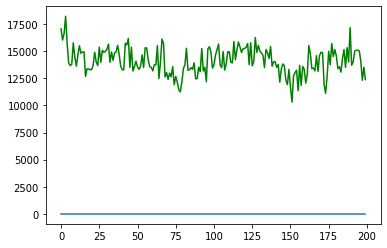

In [36]:
pred = model.predict(xtest)
plt.plot(pred.flatten())
plt.plot(ytest.flatten(), color = 'g')

In [37]:
mse = (np.square(ytest.flatten() - pred.flatten())).mean(axis=0)
mse

199636098.75746322

-------

In [38]:
from tcn import TCN, tcn_full_summary

tcn_layer = TCN(input_shape=(1,40))


model2 = Sequential()
model2.add(TCN(input_shape=(1,40),  return_sequences=True, use_batch_norm=True, activation = 'relu', padding = 'causal', dropout_rate = 0.3))
model2.add(LSTM(256, activation='relu', return_sequences=True))
model2.add(Dense(1, activation = 'relu'))

model2.compile(loss='mape', optimizer='adam', metrics = tf.keras.metrics.MeanAbsolutePercentageError())
hist2 = model2.fit(X_train_selec[-3200:-300], y_train[-3200:-300], epochs=100, batch_size=16, verbose=1, validation_split=0.1)

xtest = X_train_selec[-300:]
ytest = y_train[-300:]

### MODELO RAPIDO: CONVERGE EN CUATRO EPOCAS (12 s)

Epoch 1/100
94/94 [==============================] - 10s 34ms/step - loss: 99.5937 - mean_absolute_percentage_error: 99.5937 - val_loss: 98.8680 - val_mean_absolute_percentage_error: 98.8680
Epoch 2/100
94/94 [==============================] - 3s 28ms/step - loss: 92.7492 - mean_absolute_percentage_error: 92.7492 - val_loss: 88.3296 - val_mean_absolute_percentage_error: 88.3296
Epoch 3/100
94/94 [==============================] - 2s 25ms/step - loss: 67.9530 - mean_absolute_percentage_error: 67.9530 - val_loss: 56.9272 - val_mean_absolute_percentage_error: 56.9272
Epoch 4/100
94/94 [==============================] - 2s 25ms/step - loss: 18.2406 - mean_absolute_percentage_error: 18.2406 - val_loss: 29.6899 - val_mean_absolute_percentage_error: 29.6899
Epoch 5/100
94/94 [==============================] - 2s 25ms/step - loss: 6.7061 - mean_absolute_percentage_error: 6.7061 - val_loss: 23.3414 - val_mean_absolute_percentage_error: 23.3414
Epoch 6/100
94/94 [==============================] 

Epoch 45/100
94/94 [==============================] - 2s 24ms/step - loss: 5.5638 - mean_absolute_percentage_error: 5.5638 - val_loss: 5.5687 - val_mean_absolute_percentage_error: 5.5687
Epoch 46/100
94/94 [==============================] - 2s 24ms/step - loss: 5.6865 - mean_absolute_percentage_error: 5.6865 - val_loss: 5.6055 - val_mean_absolute_percentage_error: 5.6055
Epoch 47/100
94/94 [==============================] - 2s 26ms/step - loss: 5.6439 - mean_absolute_percentage_error: 5.6439 - val_loss: 5.7333 - val_mean_absolute_percentage_error: 5.7333
Epoch 48/100
94/94 [==============================] - 2s 26ms/step - loss: 6.0432 - mean_absolute_percentage_error: 6.0432 - val_loss: 5.6916 - val_mean_absolute_percentage_error: 5.6916
Epoch 49/100
94/94 [==============================] - 2s 25ms/step - loss: 5.5879 - mean_absolute_percentage_error: 5.5879 - val_loss: 5.7173 - val_mean_absolute_percentage_error: 5.7173
Epoch 50/100
94/94 [==============================] - 2s 24ms/ste

Epoch 89/100
94/94 [==============================] - 2s 24ms/step - loss: 5.4283 - mean_absolute_percentage_error: 5.4283 - val_loss: 5.7667 - val_mean_absolute_percentage_error: 5.7667
Epoch 90/100
94/94 [==============================] - 2s 25ms/step - loss: 5.2230 - mean_absolute_percentage_error: 5.2230 - val_loss: 5.9860 - val_mean_absolute_percentage_error: 5.9860
Epoch 91/100
94/94 [==============================] - 2s 25ms/step - loss: 5.3440 - mean_absolute_percentage_error: 5.3440 - val_loss: 5.7931 - val_mean_absolute_percentage_error: 5.7931
Epoch 92/100
94/94 [==============================] - 2s 25ms/step - loss: 5.4639 - mean_absolute_percentage_error: 5.4639 - val_loss: 5.7226 - val_mean_absolute_percentage_error: 5.7226
Epoch 93/100
94/94 [==============================] - 3s 28ms/step - loss: 5.3296 - mean_absolute_percentage_error: 5.3296 - val_loss: 5.6463 - val_mean_absolute_percentage_error: 5.6463
Epoch 94/100
94/94 [==============================] - 2s 24ms/ste

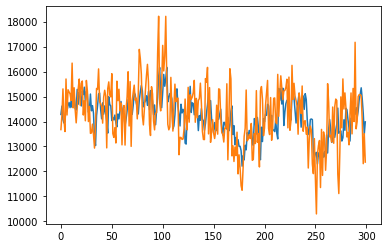

In [39]:
pred2 = model2.predict(xtest)
plt.plot(pred2.flatten())
plt.plot(ytest.flatten())

In [40]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fbefc466580>>

-----

In [41]:
model3 = Sequential()
model3.add(TCN(input_shape=(1,40),  return_sequences=True, use_batch_norm=True, activation = 'relu', padding = 'causal', dropout_rate = 0.3))
model3.add(TCN(return_sequences=True, use_batch_norm=True, activation = 'relu', padding = 'causal', dropout_rate = 0.3))
model3.add(Dense(1, activation = 'relu'))

model3.compile(loss='mape', optimizer='adam', metrics = tf.keras.metrics.MeanAbsolutePercentageError())
hist3 = model3.fit(X_train_selec[-3200:-300], y_train[-3200:-300], epochs=100, batch_size=16, verbose=1, validation_split=0.1)

xtest = X_train_selec[-300:]
ytest = y_train[-300:]


Epoch 1/100
94/94 [==============================] - 15s 53ms/step - loss: 99.9858 - mean_absolute_percentage_error: 99.9858 - val_loss: 99.8950 - val_mean_absolute_percentage_error: 99.8950
Epoch 2/100
94/94 [==============================] - 4s 40ms/step - loss: 99.8360 - mean_absolute_percentage_error: 99.8360 - val_loss: 99.4959 - val_mean_absolute_percentage_error: 99.4959
Epoch 3/100
94/94 [==============================] - 4s 40ms/step - loss: 99.6346 - mean_absolute_percentage_error: 99.6346 - val_loss: 99.2712 - val_mean_absolute_percentage_error: 99.2712
Epoch 4/100
94/94 [==============================] - 4s 40ms/step - loss: 99.2832 - mean_absolute_percentage_error: 99.2832 - val_loss: 99.5462 - val_mean_absolute_percentage_error: 99.5462
Epoch 5/100
94/94 [==============================] - 4s 40ms/step - loss: 98.7950 - mean_absolute_percentage_error: 98.7950 - val_loss: 99.1162 - val_mean_absolute_percentage_error: 99.1162
Epoch 6/100
94/94 [==============================

Epoch 44/100
94/94 [==============================] - 4s 40ms/step - loss: 10.6535 - mean_absolute_percentage_error: 10.6535 - val_loss: 10.0563 - val_mean_absolute_percentage_error: 10.0563
Epoch 45/100
94/94 [==============================] - 4s 40ms/step - loss: 9.4916 - mean_absolute_percentage_error: 9.4916 - val_loss: 20.7698 - val_mean_absolute_percentage_error: 20.7698
Epoch 46/100
94/94 [==============================] - 4s 40ms/step - loss: 8.5062 - mean_absolute_percentage_error: 8.5062 - val_loss: 14.8726 - val_mean_absolute_percentage_error: 14.8726
Epoch 47/100
94/94 [==============================] - 4s 39ms/step - loss: 7.7825 - mean_absolute_percentage_error: 7.7825 - val_loss: 16.2976 - val_mean_absolute_percentage_error: 16.2976
Epoch 48/100
94/94 [==============================] - 4s 40ms/step - loss: 6.8882 - mean_absolute_percentage_error: 6.8882 - val_loss: 8.8472 - val_mean_absolute_percentage_error: 8.8472
Epoch 49/100
94/94 [==============================] - 4

Epoch 88/100
94/94 [==============================] - 4s 40ms/step - loss: 5.9576 - mean_absolute_percentage_error: 5.9576 - val_loss: 6.1552 - val_mean_absolute_percentage_error: 6.1552
Epoch 89/100
94/94 [==============================] - 4s 40ms/step - loss: 5.8601 - mean_absolute_percentage_error: 5.8601 - val_loss: 6.1033 - val_mean_absolute_percentage_error: 6.1033
Epoch 90/100
94/94 [==============================] - 4s 40ms/step - loss: 5.8747 - mean_absolute_percentage_error: 5.8747 - val_loss: 6.2255 - val_mean_absolute_percentage_error: 6.2255
Epoch 91/100
94/94 [==============================] - 4s 40ms/step - loss: 5.6882 - mean_absolute_percentage_error: 5.6882 - val_loss: 6.0386 - val_mean_absolute_percentage_error: 6.0386
Epoch 92/100
94/94 [==============================] - 4s 39ms/step - loss: 5.7521 - mean_absolute_percentage_error: 5.7521 - val_loss: 5.9829 - val_mean_absolute_percentage_error: 5.9829
Epoch 93/100
94/94 [==============================] - 4s 39ms/ste

CPU times: user 1.62 s, sys: 64.8 ms, total: 1.68 s
Wall time: 1.55 s


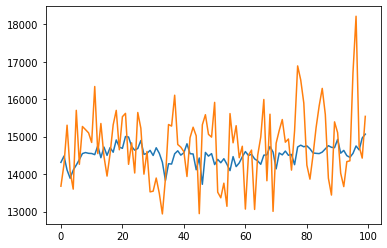

In [42]:
%time pred3 = model3.predict(xtest)
plt.plot(pred3.flatten()[:100])
plt.plot(ytest.flatten()[:100])

----

In [44]:
model4 = Sequential()
model4.add(LSTM(256, activation='relu', input_shape=(1,40),  return_sequences=True))
model4.add(TCN(return_sequences=True, use_batch_norm=True, activation = 'relu', padding = 'causal', dropout_rate = 0.3))
model4.add(TCN(return_sequences=True, use_batch_norm=True, activation = 'relu', padding = 'causal', dropout_rate = 0.3))
model4.add(Dense(1, activation = 'relu'))

model4.compile(loss='mape', optimizer='adam', metrics = tf.keras.metrics.MeanAbsolutePercentageError())
hist4 = model4.fit(X_train_selec[-3200:-300], y_train[-3200:-300], epochs=100, batch_size=16, verbose=1, validation_split=0.1)

xtest = X_train_selec[-300:]
ytest = y_train[-300:]


Epoch 1/100
94/94 [==============================] - 17s 59ms/step - loss: 99.9665 - mean_absolute_percentage_error: 99.9665 - val_loss: 99.9530 - val_mean_absolute_percentage_error: 99.9530
Epoch 2/100
94/94 [==============================] - 4s 43ms/step - loss: 99.8181 - mean_absolute_percentage_error: 99.8181 - val_loss: 99.8294 - val_mean_absolute_percentage_error: 99.8294
Epoch 3/100
94/94 [==============================] - 4s 43ms/step - loss: 99.6219 - mean_absolute_percentage_error: 99.6219 - val_loss: 99.6003 - val_mean_absolute_percentage_error: 99.6003
Epoch 4/100
94/94 [==============================] - 4s 44ms/step - loss: 99.3539 - mean_absolute_percentage_error: 99.3539 - val_loss: 99.3533 - val_mean_absolute_percentage_error: 99.3533
Epoch 5/100
94/94 [==============================] - 4s 43ms/step - loss: 98.9837 - mean_absolute_percentage_error: 98.9837 - val_loss: 99.0912 - val_mean_absolute_percentage_error: 99.0912
Epoch 6/100
94/94 [==============================

Epoch 44/100
94/94 [==============================] - 9s 93ms/step - loss: 17.1485 - mean_absolute_percentage_error: 17.1485 - val_loss: 8.0064 - val_mean_absolute_percentage_error: 8.0064
Epoch 45/100
94/94 [==============================] - 9s 96ms/step - loss: 17.0212 - mean_absolute_percentage_error: 17.0212 - val_loss: 8.6970 - val_mean_absolute_percentage_error: 8.6970
Epoch 46/100
94/94 [==============================] - 6s 61ms/step - loss: 14.7898 - mean_absolute_percentage_error: 14.7898 - val_loss: 7.5003 - val_mean_absolute_percentage_error: 7.5003
Epoch 47/100
94/94 [==============================] - 4s 44ms/step - loss: 14.1328 - mean_absolute_percentage_error: 14.1328 - val_loss: 7.0014 - val_mean_absolute_percentage_error: 7.0014
Epoch 48/100
94/94 [==============================] - 4s 47ms/step - loss: 14.0512 - mean_absolute_percentage_error: 14.0512 - val_loss: 9.1377 - val_mean_absolute_percentage_error: 9.1377
Epoch 49/100
94/94 [==============================] - 4

Epoch 88/100
94/94 [==============================] - 4s 45ms/step - loss: 5.7984 - mean_absolute_percentage_error: 5.7984 - val_loss: 6.2833 - val_mean_absolute_percentage_error: 6.2833
Epoch 89/100
94/94 [==============================] - 4s 45ms/step - loss: 5.8909 - mean_absolute_percentage_error: 5.8909 - val_loss: 6.2392 - val_mean_absolute_percentage_error: 6.2392
Epoch 90/100
94/94 [==============================] - 4s 44ms/step - loss: 5.6942 - mean_absolute_percentage_error: 5.6942 - val_loss: 6.1370 - val_mean_absolute_percentage_error: 6.1370
Epoch 91/100
94/94 [==============================] - 4s 44ms/step - loss: 5.8380 - mean_absolute_percentage_error: 5.8380 - val_loss: 6.1594 - val_mean_absolute_percentage_error: 6.1594
Epoch 92/100
94/94 [==============================] - 4s 44ms/step - loss: 5.9370 - mean_absolute_percentage_error: 5.9370 - val_loss: 6.2034 - val_mean_absolute_percentage_error: 6.2034
Epoch 93/100
94/94 [==============================] - 4s 44ms/ste

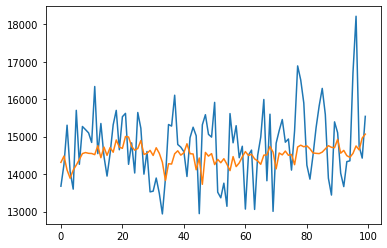

In [45]:
pred3 = model3.predict(xtest)
plt.plot(ytest.flatten()[:100])
plt.plot(pred3.flatten()[:100])


------

In [46]:
import statsmodels.api as sm

In [47]:
X_train_selec.squeeze()

array([[0.64650895, 0.68044373, 0.69488713, ..., 0.61837784, 0.58064743,
        0.68873814],
       [0.68044373, 0.67148148, 0.65007931, ..., 0.54208088, 0.58064743,
        0.68873814],
       [0.67148148, 0.73503836, 0.67891955, ..., 0.54208088, 0.69651562,
        0.68873814],
       ...,
       [0.684519  , 0.8557538 , 0.71021236, ..., 0.44549065, 0.69972156,
        0.7167788 ],
       [0.8557538 , 0.73936608, 0.55945901, ..., 0.44549065, 0.43094158,
        0.56438161],
       [0.73936608, 0.80621835, 0.46599035, ..., 0.49465865, 0.43094158,
        0.56438161]])

In [48]:
modelg = sm.GLM(y_train[-3200:-300].squeeze(), X_train_selec[-3200:-300].squeeze(), family=sm.families.Gaussian())
%time glmfit = modelg.fit()

CPU times: user 42.6 ms, sys: 92.8 ms, total: 135 ms
Wall time: 34.3 ms


CPU times: user 6.3 ms, sys: 24.9 ms, total: 31.2 ms
Wall time: 11.5 ms


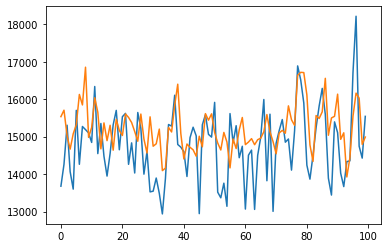

In [49]:
%time predg = glmfit.predict(xtest.squeeze())

plt.plot(ytest.flatten()[:100])
plt.plot(predg.flatten()[:100])